In [1]:
import os

os.getcwd()


'/Users/benwolley/Documents/vscode/repo1'

In [6]:
#average gas price for past year by day/hour (issue with daily trading hour rectangles)
import pandas as pd
import matplotlib.pyplot as plt


In [14]:
#read data
data = pd.read_csv("eth_data2.csv")
data

,hour,avg_base_fee,avg_gas_limit,avg_gas_used,avg_tcount
0,2022-09-18 00:00:00,3.123934e+09,2.999990e+07,1.543564e+07,164.513514
1,2022-09-18 01:00:00,2.707575e+09,2.999970e+07,1.544716e+07,163.814815
2,2022-09-18 02:00:00,3.744840e+09,2.999950e+07,1.525848e+07,156.182432
3,2022-09-18 03:00:00,3.053517e+09,2.999951e+07,1.530115e+07,148.802676
4,2022-09-18 04:00:00,3.509827e+09,2.999990e+07,1.521047e+07,151.391304
...,...,...,...,...,...
8755,2023-09-17 19:00:00,1.017608e+10,2.999712e+07,1.496930e+07,131.972881
8756,2023-09-17 20:00:00,9.049189e+09,2.999832e+07,1.518189e+07,136.864865
8757,2023-09-17 21:00:00,9.925678e+09,2.999751e+07,1.504643e+07,127.316327
8758,2023-09-17 22:00:00,8.471073e+09,2.999680e+07,1.507518e+07,117.593857


In [16]:
#convert timestamp to posix
data['hour'] = pd.to_datetime(data['hour'], format='%Y-%m-%d %H:%M:%S') #make sure it has same time format

# new column with weekday/hour formatted to match the x-axis labels
data['weekday_and_hour'] = data['hour'].dt.strftime('%A %H:%M:%S')  # Changed from '%A %H:00:00'
print(data['hour'])

0      2022-09-18 00:00:00
1      2022-09-18 01:00:00
2      2022-09-18 02:00:00
3      2022-09-18 03:00:00
4      2022-09-18 04:00:00
               ...        
8755   2023-09-17 19:00:00
8756   2023-09-17 20:00:00
8757   2023-09-17 21:00:00
8758   2023-09-17 22:00:00
8759   2023-09-17 23:00:00
Name: hour, Length: 8760, dtype: datetime64[ns]


In [17]:
#group by weekday_and_hour and find average for groupings of the base price of gas
average_data = data.groupby('weekday_and_hour')['avg_base_fee'].mean() / 1e8
average_data

weekday_and_hour
Friday 00:00:00       229.994826
Friday 01:00:00       232.034410
Friday 02:00:00       237.649217
Friday 03:00:00       218.916565
Friday 04:00:00       202.521833
                         ...    
Wednesday 19:00:00    353.804893
Wednesday 20:00:00    362.047908
Wednesday 21:00:00    343.212539
Wednesday 22:00:00    303.645344
Wednesday 23:00:00    267.548879
Name: avg_base_fee, Length: 168, dtype: float64

In [18]:

#reset the index and rename the column
average_data = average_data.reset_index().rename(columns={'avg_base_fee': 'Average_avg_base_fee'})
average_data

,weekday_and_hour,Average_avg_base_fee
0,Friday 00:00:00,229.994826
1,Friday 01:00:00,232.034410
2,Friday 02:00:00,237.649217
3,Friday 03:00:00,218.916565
4,Friday 04:00:00,202.521833
...,...,...
163,Wednesday 19:00:00,353.804893
164,Wednesday 20:00:00,362.047908
165,Wednesday 21:00:00,343.212539
166,Wednesday 22:00:00,303.645344


In [19]:

#order for weekdays, needed for aggregation
weekday_order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]

In [26]:
#create x-axis labels
#(each day, every 4 hours ONLY FOR LABELING) - try later with every 4th hour for label, nvm just reduced ticks below
x_labels = []
for day in weekday_order:
    for hour in range(24):  #this will iterate over 24 hours
       x_labels.append(f"{day} {hour:02d}:00:00")

#x_labels

In [29]:
#sort df by custom order
average_data['weekday_and_hour'] = pd.Categorical(average_data['weekday_and_hour'], categories=x_labels, ordered=True)
average_data = average_data.sort_values('weekday_and_hour')
#average_data
#type(average_data['weekday_and_hour'])

pandas.core.series.Series

In [30]:
#convert 'weekday_and_hour' back to string before using it in scatter plot
average_data['weekday_and_hour'] = average_data['weekday_and_hour'].astype(str)
#type(average_data['weekday_and_hour'])

pandas.core.series.Series

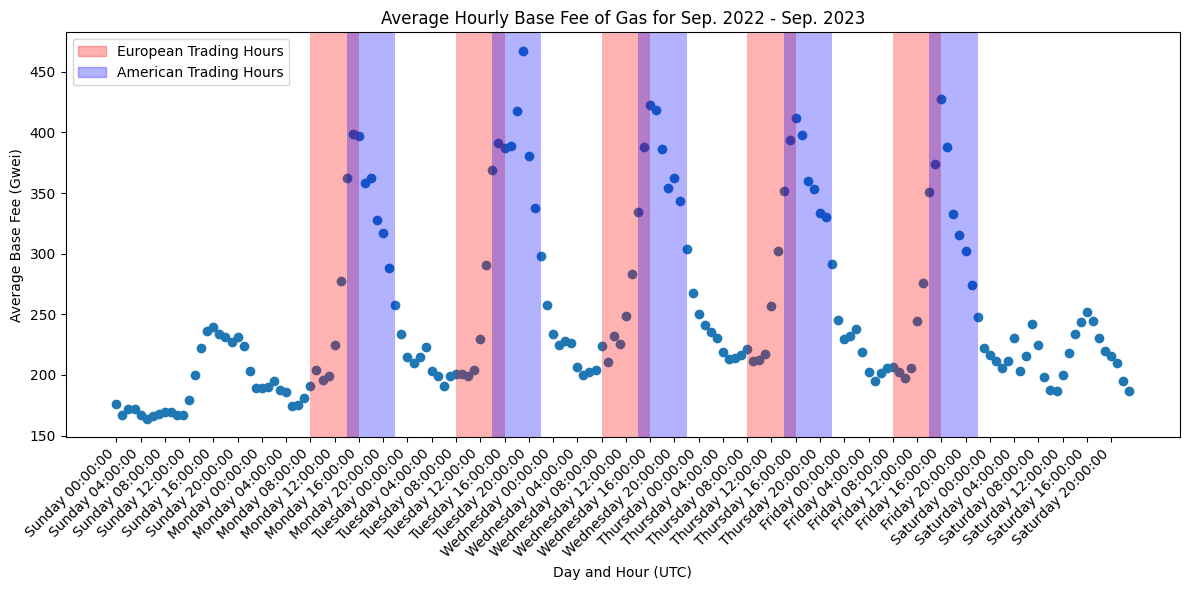

In [41]:
#scatterplot
#print(average_data) #its correct going
plt.figure(figsize=(12, 6))
plt.scatter(average_data['weekday_and_hour'], average_data['Average_avg_base_fee'])

#rotate x axis labs 45 degrees
plt.xticks(rotation=45, ha='right')

# Reduce the number of x-axis ticks (e.g., show every 4th tick) - used chatGPT for help with this instead of the above x_label function
#n = 4 - below commented out exaple plotted data correctly but labels were wrong
#plt.xticks(average_data.index[::n], average_data['weekday_and_hour'].iloc[::n], rotation=45, ha='right')
n = 4
plt.xticks(range(0, len(average_data), n), average_data['weekday_and_hour'].iloc[::n], rotation=45, ha='right')

#trading hours
european_trading_hours = ("08:00:00", "16:30:00")
american_trading_hours = ("14:00:00", "21:30:00")

#rectangles
#this worked, add notes to understand
colors = ['red', 'blue']
for i, day in enumerate(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]): #iterates over days with 2 values, i=index of day (0,1,2..) and day=day name
    for j, hour_range in enumerate([(8, 16.5), (14, 21.5)]): #iterates over list w/ tuples, j=index, hour_range=hour range provided
        start, end = hour_range
        color = colors[j] #based on index
        plt.axvspan(f"{day} {start:02.0f}:00:00", f"{day} {end:02.0f}:00:00", facecolor=color, alpha=0.3, ymin=0, ymax=250)
#plt.axvspan used to create vertical rectangles, using day, start, end

#axis labels/title
plt.xlabel('Day and Hour (UTC)')
plt.ylabel('Average Base Fee (Gwei)')
plt.title('Average Hourly Base Fee of Gas for Sep. 2022 - Sep. 2023')

#legends (worked)
legend_labels = ['European Trading Hours', 'American Trading Hours']
legend_handles = [plt.Rectangle((0, 0), 1, 1, color='red', alpha=0.3), plt.Rectangle((0, 0), 1, 1, color='blue', alpha=0.3)]
#above manually creates the legend, .rectangle renders a square at for legend w/ above labels
plt.legend(legend_handles, legend_labels, loc='upper left')




#final plot
plt.tight_layout()
plt.show()